In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
import os
import shutil
import time
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import os
from PIL import Image
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
WIDTH = 128 #tamaño de nuestras imágenes
HEIGHT = 128
despierto = glob('Nivel_1/*.jpg')
dormido= glob('Nivel_3/*.jpg')
print("tamaño original de despierto:",len(despierto))
print("tamaño original de dormido:",len(dormido))

tamaño original de despierto: 10583
tamaño original de dormido: 10583


In [4]:
#COMPILAR SOLO SI ES NECESARIO

WIDTH = 128 #tamaño de nuestras imágenes
HEIGHT = 128
#creamos   nuestra carpeta de test y de train
despierto = glob('NONSLEEPY/*.jpg')
dormido= glob('SLEEPY/*.jpg')
print("tamaño original de despierto:",len(despierto))
print("tamaño original de dormido:",len(dormido))


#VAMOS A TENER EN TOTAL 30 mil imágenes
cantidadTotal=15000 #LA MITAD
image_directory = 'SLEEPY/'
SIZE = HEIGHT
dataset = []
datagen = ImageDataGenerator(
        rotation_range=15,     #Random rotation between 0 and 45
        width_shift_range=0.2,   #% shift
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')    #Also try nearest, constant, reflect, wrap


my_images = os.listdir(image_directory)

for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE)) #resize
        dataset.append(np.array(image))
x = np.array(dataset)
print("tenemos:" , len(x))
 #tenemos 9719, entonces restamos 20mil menos 9719 para obtener la cant que nos falta
falta=cantidadTotal-len(x)
print("falta:" , falta)
#si no le ponemos el batch_size, crea por defecto 32 imagenes
i = 0
for batch in datagen.flow(x,  batch_size=falta,
                          save_to_dir='SLEEPY_DA', 
                          save_prefix='aug', 
                          save_format='jpg'):
    i=i+ 1
    if i < falta:
        break  # otherwise the generator would loop indefinitely  

tenemos: 9719
falta: 5281


In [ ]:
#COMPILAR SOLO SI FALTA IMAGENES PARA ESTA CLASE
#VAMOS A TENER EN TOTAL 30 mil imágenes
cantidadTotal=15000 #MITAD DEL TOTAL
image_directory = 'NONSLEEPY/'

dataset = []
my_images = os.listdir(image_directory)

for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE)) #resize
        dataset.append(np.array(image))
x = np.array(dataset)
print("tenemos:" , len(x))
 #tenemos 9719, entonces restamos 20mil menos 9719 para obtener la cant que nos falta
falta=cantidadTotal-len(x)
print("falta:" , falta)
#si no le ponemos el batch_size, crea por defecto 32 imagenes
i = 0
for batch in datagen.flow(x,  batch_size=falta,
                          save_to_dir='NONSLEEPY_DA', 
                          save_prefix='aug', 
                          save_format='jpg'):
    i=i+ 1
    if i < falta:
        break  # otherwise the generator would loop indefinitely  

In [7]:
#COMPILAR SOLO SI ES NECESARIO
import shutil
#COMO NOS SOBRA IMÁGENES, VAMOS A QUITAR PARA SOLO TENER 15MIL
cantidadTotal=15000 #MITAD DEL TOTAL
image_directory = 'NONSLEEPY/'

dataset = []
my_images = os.listdir(image_directory)
cont=0
for i in my_images:
    shutil.copy("NONSLEEPY/"+i, "NONSLEEPY_DA/"+i)
    cont+=1
    if (cont>cantidadTotal):
        break
    

In [3]:
despierto_train, despierto_test = train_test_split(despierto, test_size=0.2)
dormido_train, dormido_test = train_test_split(dormido, test_size=0.2)
carpetas= ["TRAIN","TEST"]
#direcciones para crear carpetas
clases=["despierto", "dormido"]

In [4]:
#EJECUTAR SOLO SI NO SE TIENE LAS CARPETAS   
for i in carpetas:
    os.mkdir(i)
    for j in clases:
        os.mkdir(i+"/"+j)
        if(i=="TRAIN"):
            if(j=="despierto"):
                for k in despierto_train:
                    shutil.copy(k,i+"/"+j)
            if(j=="dormido"):
                for k in dormido_train:
                    shutil.copy(k,i+"/"+j)

        if(i=="TEST"):
            if(j=="despierto"):
                for k in despierto_test:
                    shutil.copy(k,i+"/"+j)
            if(j=="dormido"):
                for k in dormido_test:
                    shutil.copy(k,i+"/"+j)

In [5]:
TRAIN_DIR = 'TRAIN'
TEST_DIR = 'TEST'


files = ' '.join(despierto_test)
files = ' '.join(dormido_test)

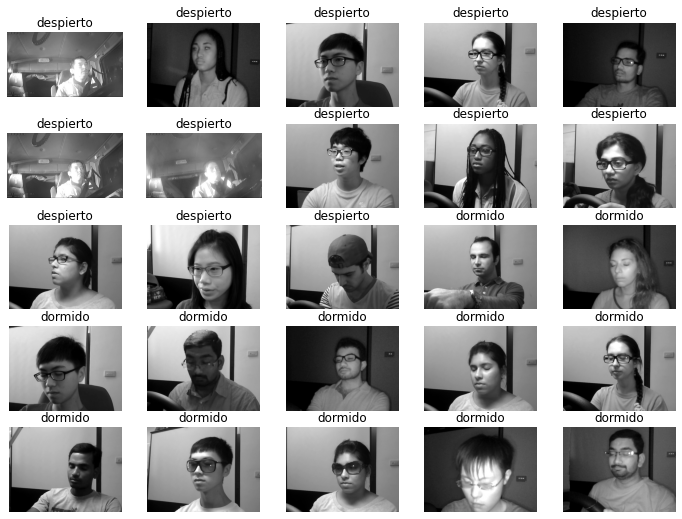

In [6]:


despierto = np.random.choice(despierto_train, 12)
dormido = np.random.choice(dormido_train, 13)


data = np.concatenate((despierto, dormido))
labels = 13 * ['despierto'] + 12 *['dormido']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [7]:

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:



BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#FILL MODE:
#nearest: expandir o jalar la imagen
#constant: color entero, por defecto es negro 
#reflect: efecto de espejo, que disimula mucho cuando aumenta, es demasiado bueno
#wrap: efecto de espejo pero malo
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


In [9]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 16932 images belonging to 2 classes.
Found 4234 images belonging to 2 classes.


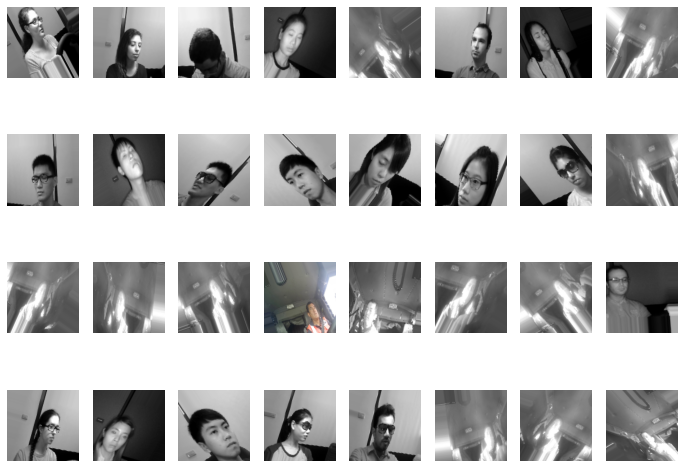

In [10]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [11]:
y_batch.shape

(32, 2)

In [12]:
# EJECUTAR SOLO SI SE DESEA CON STEPS POR EPOCHS Y VALIDATION STEPS
EPOCHS = 100
BATCH_SIZE = 32
STEPS_PER_EPOCH = 20
VALIDATION_STEPS = 64

MODEL_FILE = 'filename.model'
start = time.time() #tomamos medida del tiempo
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator, #test
    validation_steps=VALIDATION_STEPS)

end = time.time() #paramos el tiempo
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print()
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
#model.save(MODEL_FILE)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
20/20 [==============================] - 30s 2s/step - loss: 1.1467 - accuracy: 0.6187 - val_loss: 0.9179 - val_accuracy: 0.6484
Epoch 2/100
20/20 [==============================] - 29s 1s/step - loss: 1.0875 - accuracy: 0.6328 - val_loss: 0.8073 - val_accuracy: 0.6812
Epoch 3/100
20/20 [==============================] - 28s 1s/step - loss: 1.1048 - accuracy: 0.6359 - val_loss: 0.8022 - val_accuracy: 0.6890
Epoch 4/100
20/20 [==============================] - 29s 1s/step - loss: 1.1166 - accuracy: 0.6203 - val_loss: 0.9792 - val_accuracy: 0.6733
Epoch 5/100
20/20 [==============================] - 29s 1s/step - loss: 0.9776 - accuracy: 0.6484 - val_loss: 0.6863 - val_accuracy: 0.6953
Epoch 6/100
20/20 [==============================] - 28s 1s/step - loss: 1.0523 - accuracy: 0.6516 - val_loss: 0.6984 - val_accuracy: 0.7061
Epoch 7/100
20/20 [==============================] - 27s 1s/step - loss: 0.960

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32


MODEL_FILE = 'filename.model'
start = time.time() #tomamos medida del tiempo
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
    ) #test

end = time.time() #paramos el tiempo
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print()
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
#model.save(MODEL_FILE)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("dormido", "despierto")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [14]:
start = time.time() #tomamos medida del tiempo
img = image.load_img('TEST/despierto/glasses_corregido321.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)
end = time.time() #paramos el tiempo

In [15]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:00:02.20


In [82]:
start = time.time() #tomamos medida del tiempo
img = image.load_img('TEST/despierto/glasses_corregido365.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)
preds

array([0.28421983, 0.71578014], dtype=float32)

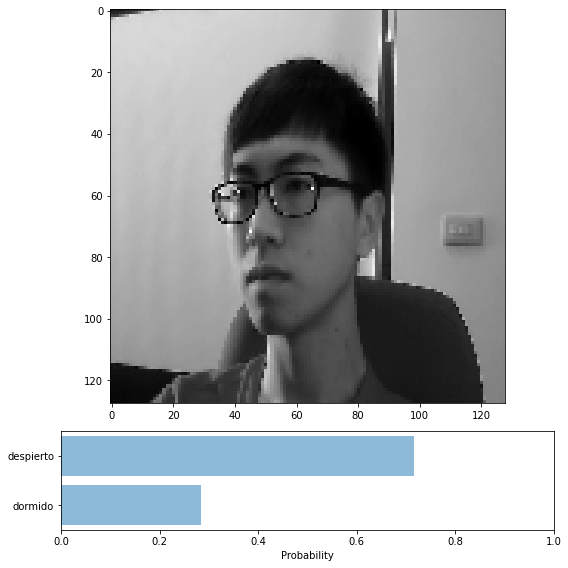

In [83]:
plot_preds(np.asarray(img), preds)
end = time.time() #paramos el tiempo

In [36]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
#history.history['loss']

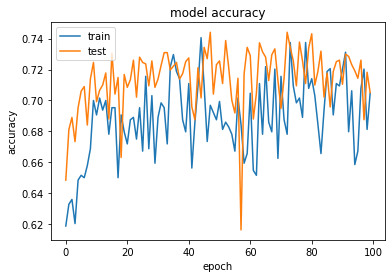

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


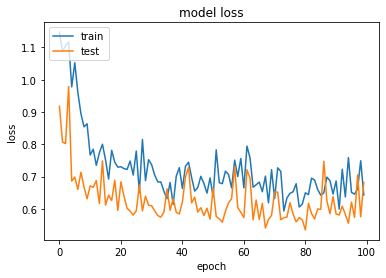

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [85]:
# Guardar el Modelo
model.save('model_inception_siso_with_nthu_10k_with_2class.h5')

In [88]:
import keras
new_model = keras.models.load_model('model_inception_siso_with_nthu_10k_with_2class.h5')

In [90]:
new_predictions = new_model.predict(validation_generator)

In [91]:
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

NotImplementedError: Cannot convert a symbolic Tensor (dense/Softmax:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported